In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Notes
This notebook shows an example using PODPAC for an application. It is meant to serve as inspiration for creating new applications. It will likely not run for most users. This is because of 2 reasons:

1. This notebook uses our settings files where we recorded our own Earth Data Login username and password. Unless you did the same, the SMAP node will not be authenticated. Look at the [SMAP-level4-data-access.ipynb](SMAP-level4-data-access.ipynb) notebook for information. 
2. This notebook uses our settings files to retrieve the URL for our WCS server. See the line: `podpac.core.utils.load_setting('WCSServerUrl')` . We saved this custom setting to our settings file for convenience. You can do something similar to retrieve data from your own, or another public WCS server. 

In [2]:
import podpac

# Example using PODPAC to develop a soil moisture downscaling algorithm

## Obtain large scale soil moisture from NASA SMAP mission, and examine it

In [3]:
from podpac import datalib
from podpac.datalib import smap

datalib.smap.SMAP_PRODUCT_MAP.product.data.tolist()

['SPL4SMAU.003',
 'SPL4SMGP.003',
 'SPL3SMA.003',
 'SPL3SMAP.003',
 'SPL3SMP.004',
 'SPL4SMLM.003']

In [4]:
product = 'SPL4SMAU.003'   # Level 4 soil moisture analysis update
smap = datalib.smap.SMAP(product=product, interpolation='nearest_preview')
# The available coordinates are built from all available SMAP sources for this product
# This requires multiple http get requests from the DAAC OpenDAP server, and may take a while
# Because of this, the results are cached after the first run
smap.native_coordinates  

<class 'podpac.core.coordinate.Coordinate'>
	time: Coord: Bounds[2015-03-31T03:00:00, 2017-11-13T00:00:00], N[7664], ctype["segment"]
	lat: Coord: Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype["segment"]
	lon: Coord: Bounds[-179.95474243164062, 179.95474243164062], N[3856], ctype["segment"]

A data source's `native_coordinates` describes the "coverage" of the data, that is, it gives the lat,lon coordinates and times for which the data is available. Thus, the data is natively available for those coordinates.

However, a user may request any coordinates, and PODPAC will do the requested interpolation. This will happen without downloading the entire dataset, or any manual data wrangling.

Let's have a look at a global view of SMAP data at a coarse resolution: 

(181, 361, 1)


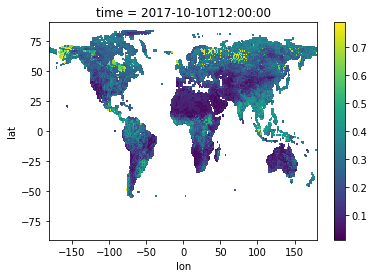

In [5]:
coordinates_world = \
    podpac.Coordinate(lat=(-90, 90, 1.),
                      lon=(-180, 180, 1.),
                      time='2017-10-10T12:00:00', 
                      order=['lat', 'lon', 'time'])
output = smap.execute(coordinates_world)
print (output.shape)
output[..., 0].plot()

MIN, MAX =  0.10946866124868393 0.595804750919342


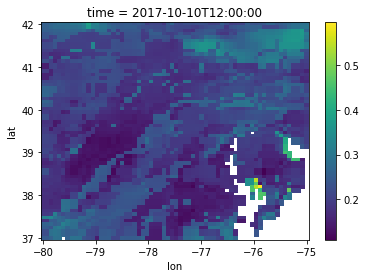

In [6]:
# Let's zoom into a region of interest to test our algorithm
figure()
coordinates_zoom = podpac.Coordinate(lat=(42, 37., 64),
                                     lon=(-80.0, -75, 64),
                                     time='2017-10-10T12:00:00', 
                               order=['lat', 'lon', 'time'])
smap.interpolation = 'nearest'
output = smap.execute(coordinates_zoom)
print ("MIN, MAX = ", output.min().item(), output.max().item())
output.plot()

MIN, MAX =  0.2075897604227066 0.2637057900428772


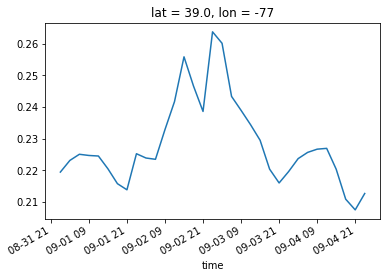

In [7]:
# Let's find a wet date
figure()
coordinates_point = \
    podpac.Coordinate(lat=39., lon=-77, 
                      time=('2017-09-01', '2017-09-05', '3,h'), 
                      order=['lat', 'lon', 'time'])
smap.threaded = True
smap.n_threads = 8
output = smap.execute(coordinates_point)
smap.threaded = False
print ("MIN, MAX = ", output.min().item(), output.max().item())
output.plot()

# Obtain soil properties from SMAP

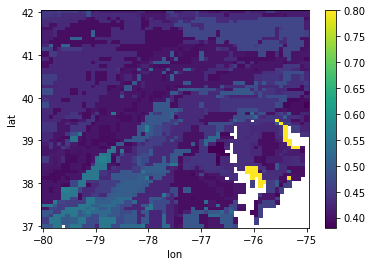

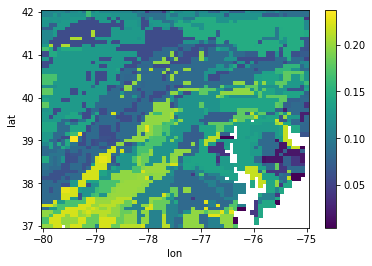

In [8]:
porosity = datalib.smap.SMAPPorosity(interpolation='nearest')
wilt = datalib.smap.SMAPWilt(interpolation='nearest')
figure()
porosity.execute(coordinates_zoom).plot()
figure()
wilt.execute(coordinates_zoom).plot()


## Obtain Topographic Wetness from another source


In [9]:
coordinates_test = podpac.Coordinate(lat=(39.3, 39., 64), lon=(-77.0, -76.7, 64), time='2017-09-03T12:00:00', 
                               order=['lat', 'lon', 'time'])

MIN, MAX =  8.899999618530273 13.300000190734863


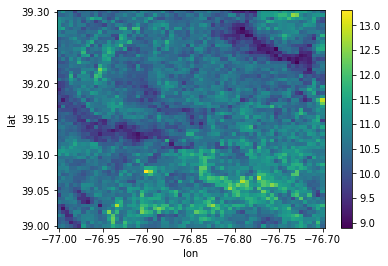

In [10]:
# Note, our WCS server resides on AWS, so access from AWS Lambda is very fast
# As such, can process data closer to where it's stored
twi = podpac.core.data.type.WCS(source=podpac.core.utils.load_setting('WCSServerUrl'),
                                layer_name="dassp.main_map.topography.elevation.TopographicWetnessIndexComposited3090m",
                            interpolation='nearest')
output = twi.execute(coordinates_test)
print ("MIN, MAX = ", output.min().item(), output.max().item())
output.plot()

MIN, MAX =  9.699999809265137 11.300000190734863


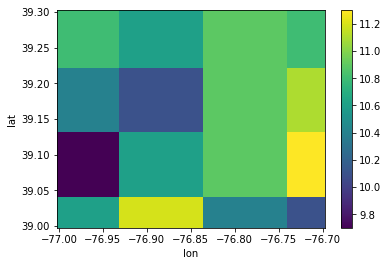

In [ ]:
# reproject twi to the coarse scale
twi_bar = podpac.core.data.type.WCS(source=podpac.core.utils.load_setting('WCSServerUrl'),
                               layer_name="dassp.main_map.topography.elevation.TopographicWetnessIndexComposited3090m",
                               interpolation='nearest')
twi_bar_r = podpac.core.data.type.ReprojectedSource(source=twi_bar, coordinates_source=smap)
output = twi_bar_r.execute(coordinates_test)
print ("MIN, MAX = ", output.min().item(), output.max().item())
output.plot()


## Write a soil-moisture downscaling algorithm

In [ ]:
smap.interpolation='bilinear'
twi_bar_r.interpolation='bilinear'
downscaled_sm = podpac.Arithmetic(A=smap, B=twi, C=twi_bar_r, D=porosity, E=wilt, 
                                  eqn="A + (D - E) / {kappa} * (B - C)", params={'kappa': 13.})
output = downscaled_sm.execute(coordinates_test)
print ("MIN, MAX = ", output.min().item(), output.max().item())
output.plot()

## Record algorithm pipeline

In [ ]:
print (downscaled_sm.pipeline_json)

## Make a few changes to the json
* Change the output type
* Add an optimization to the `TopographicWetnessIndexComposited3090m_1` node
* Clean up some errant `params` in the `TopographicWetnessIndexComposited3090m_reprojected` node

```json
{
    "nodes": {
        "SMAP_SPL4SMAU.003": {
            "node": "datalib.smap.SMAP",
            "attrs": {
                "product": "SPL4SMAU.003",
                "interpolation": "bilinear"
            }
        },
        "TopographicWetnessIndexComposited3090m": {
            "node": "core.data.type.WCS",
            "source": <WCS_SERVER_URL>,
            "attrs": {
                "interpolation": "nearest",
                "layer_name": "dassp.main_map.topography.elevation.TopographicWetnessIndexComposited3090m"
            }
        },
        "TopographicWetnessIndexComposited3090m_1": {
            "node": "core.data.type.WCS",
            "source": <WCS_SERVER_URL>,
            "attrs": {
                "interpolation": "nearest_preview",
                "layer_name": "dassp.main_map.topography.elevation.TopographicWetnessIndexComposited3090m"
            },
            "evaluate": false
        },
        "TopographicWetnessIndexComposited3090m_reprojected": {
            "node": "core.data.type.ReprojectedSource",
            "inputs": {
                "coordinates_source": "SMAP_SPL4SMAU.003",
                "source": "TopographicWetnessIndexComposited3090m_1"
            },
            "attrs": {
                "interpolation": "bilinear"
            }
        },
        "SMAPPorosity": {
            "node": "datalib.smap.SMAPPorosity",
            "source": "https://n5eil01u.ecs.nsidc.org/opendap/SMAP/SPL4SMLM.003/2015.03.31/SMAP_L4_SM_lmc_00000000T000000_Vv3030_001.h5",
            "attrs": {
                "interpolation": "nearest"
            }
        },
        "SMAPWilt": {
            "node": "datalib.smap.SMAPWilt",
            "source": "https://n5eil01u.ecs.nsidc.org/opendap/SMAP/SPL4SMLM.003/2015.03.31/SMAP_L4_SM_lmc_00000000T000000_Vv3030_001.h5",
            "attrs": {
                "interpolation": "nearest"
            }
        },
        "Arithmetic": {
            "node": "core.algorithm.algorithm.Arithmetic",
            "inputs": {
                "A": "SMAP_SPL4SMAU.003",
                "B": "TopographicWetnessIndexComposited3090m",
                "C": "TopographicWetnessIndexComposited3090m_reprojected",
                "D": "SMAPPorosity",
                "E": "SMAPWilt"
            },
            "attrs": {
                "eqn": "A + (D - E) / {kappa} * (B - C)",
                "params": {
                    "kappa": 13.0
                }
            },
        }
    },
    "outputs": [
        {
            "mode": "image",
            "format": "png",
            "vmin": 0.1,
            "vmax": 0.4,
            "nodes": [
                "Arithmetic"
            ]
        }
    ]
}
```